In [1]:
import re
import pandas as pd
from pathlib import Path
import datasets
import numpy as np
import matplotlib.pyplot as plt

from synthetic_llm_data.src.plots import plot_roc
from sklearn.metrics import auc, roc_curve

datasets.disable_caching()

/home/giovanni/Repos/synthetic_data_study/conda_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
all_dss = list(Path("./data/comparisons/").glob("**/*.json"))
# filter = "change_it_3981_samples/j"
filter = "change_it_7962_samples/j"
# filter = "change_it/j"
dss_13b_change_it = [str(ds) for ds in all_dss if re.search("s/hf_llama/llama-13b_change_it/", str(ds)) and re.search(filter, str(ds))]
dss_7b_change_it = [str(ds) for ds in all_dss if re.search("s/hf_llama/llama-7b_change_it/", str(ds)) and re.search(filter, str(ds))]
dss_m_change_it = [str(ds) for ds in all_dss if re.search("s/hf_mistral/mistral_change_it/", str(ds)) and re.search(filter, str(ds))]
all_dss = {"7b_change_it":dss_7b_change_it, "13b_change_it":dss_13b_change_it, "m_change_it":dss_m_change_it}
all_dss = {
    k: [datasets.load_dataset("json", data_files=i)["train"].to_pandas().sort_values("full_text") for i in  dss]
    for k, dss in all_dss.items()
}
all_dss = {
    k:[ds.rename({i:f"{idx}_" + i for i in ds.columns}, axis=1) for idx, ds in enumerate(dss)]
    for k, dss in all_dss.items()
}
for k, dss in all_dss.items():
    assert all(dss[0]["0_full_text"].to_list() == dss[i][f"{i}_full_text"].to_list() for i in range(len(dss)))

all_dss = {k:pd.concat(dss, axis=1) for k, dss in all_dss.items()}

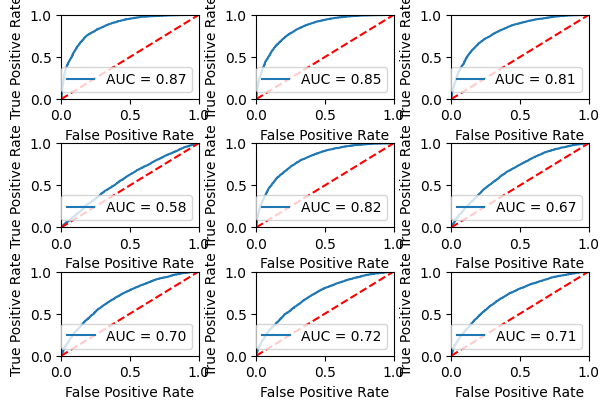

In [21]:
scores = [np.max, np.mean]
fig, ax = plt.subplots(1 + len(scores), 3, figsize=(6, 2 * (len(scores))))
plt.tight_layout()
future_ds = {}
for score_idx in range(len(scores) + 1):
    for idx, (k, ds) in enumerate(all_dss.items()):
        if score_idx == 0:
            ds["old_score"] = ds.loc[:, f"{idx}_full_text_score"]
            fpr, tpr, _ = roc_curve(ds[f"{idx}_label"], ds[f"old_score"])

        else:
            ds["new_score"] = scores[score_idx - 1](ds.loc[:, ["0_full_text_score", "1_full_text_score", "2_full_text_score"]], axis=1)
            fpr, tpr, _ = roc_curve(ds[f"{idx}_label"], ds[f"new_score"])
        
        plot_roc(fpr, tpr, ax=ax[score_idx, idx])